In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
from Bio import SeqIO
from utils import process_data, dna_one_hot, EnhancerDataset, split_dataset, evaluate_model,train_model, evaluate_regression_model,regression_model_plot
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.nn.modules.activation as activation
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

import matplotlib.pyplot as plt
import os
import pickle

sys.path.append('../model')  
from model import ConvNetDeep, DanQ, ExplaiNN,ConvNetDeep2, ExplaiNN2, ExplaiNN3, DeepSTARR

### Read and process input data

In [2]:
# Fasta file dir
fasta_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/all_sequences.fa'
# Fragment seq file dir
frag_seq_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/fragment_sequences.csv'
# Stan values file dir 
stan_values_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/stan_values.csv'
df = process_data(fasta_dir, frag_seq_dir, stan_values_dir, save_df=False)
df

            G-       G+    G-_std    Z-Score  True Positive  Expression
0      8.30052  8.58933  0.018508  15.604350           True           1
1      8.20266  8.30524  0.020297   5.053824           True           1
2      8.29027  8.61370  0.026194  12.347248           True           1
3      8.30547  8.41135  0.018621   5.685901           True           1
4      8.26727  8.29834  0.022516   1.379920          False           0
...        ...      ...       ...        ...            ...         ...
15620  8.57179  8.37986  0.071321  -2.691058          False           0
15621  8.40061  8.27249  0.041921  -3.056218          False           0
15622  8.62186  8.71746  0.059718   1.600849          False           0
15623  8.46868  8.50935  0.045470   0.894438          False           0
15624  8.22942  8.16144  0.106715  -0.637024          False           0

[28800 rows x 6 columns]


,Rep,Id,Pos1,Pos2,Pos3,G-,G-_pi,G-_sigma,G-_std,G-_pi_std,...,G+_pi,G+_sigma,G+_std,G+_pi_std,G+_sigma_std,fragment_ids,sequence,Z-Score,True Positive,Expression
0,0,0,0,0,0,8.30052,0.000181,1.082980,0.018508,3.215640e-06,...,0.000143,1.38485,0.026004,2.741250e-06,0.024427,00_00_00,TTGGTTCTATTCATTTTTCCCTCTAACTGTCCTTGTTTGGGTTGCC...,15.604350,True,1
1,0,1,1,0,0,8.20266,0.000160,1.087860,0.020297,3.126870e-06,...,0.000190,1.15149,0.019957,3.247280e-06,0.015471,01_00_00,TCGCCCCCAGTATGTGACGTGGGTGACAATGGCCCAGGTTGGAGCG...,5.053824,True,1
2,0,2,2,0,0,8.29027,0.000086,1.035640,0.026194,2.215980e-06,...,0.000089,1.37960,0.033691,2.164230e-06,0.030272,02_00_00,GAAATAATACATGATTGACGCTCTCTTTCAATGTGTCCTAACTGTT...,12.347248,True,1
3,0,3,3,0,0,8.30547,0.000180,1.043150,0.018621,3.232950e-06,...,0.000179,1.26905,0.022117,3.115050e-06,0.018697,03_00_00,TTCTTCCTCCCTTTTCCCCTTGCAAGAATTAGTATCTGGTTTGAAA...,5.685901,True,1
4,0,4,4,0,0,8.26727,0.000116,0.982851,0.022516,2.657630e-06,...,0.000108,1.06693,0.024870,2.324450e-06,0.018325,04_00_00,CTTGGGCCGCGGCGGCGCCCCCACCACCCCCGGGTTTCTAGAGCCT...,1.379920,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15620,1,15620,20,24,24,8.57179,0.000008,0.816583,0.071321,6.090920e-07,...,0.000005,1.04952,0.106717,5.317580e-07,0.088414,20_24_24,CTAAATAGCACCGCGGCGCCCGCTCTCCGGACAGTGATTAATGATA...,-2.691058,False,0
15621,1,15621,21,24,24,8.40061,0.000042,1.057010,0.041921,1.410020e-06,...,0.000022,1.06715,0.050613,1.048750e-06,0.043441,21_24_24,TGCCCCAGGAGTTTAATAGTTTCCCTTACTCGCGGGGCATTGTGTG...,-3.056218,False,0
15622,1,15622,22,24,24,8.62186,0.000019,0.989721,0.059718,9.371120e-07,...,0.000009,1.19238,0.094796,7.051260e-07,0.082170,22_24_24,ACTAGATCCTGTCACAATTCCCTGAACGCTTTGAAGGCGCGGCCTA...,1.600849,False,0
15623,1,15623,23,24,24,8.46868,0.000031,0.968123,0.045470,1.224010e-06,...,0.000029,1.13945,0.050280,1.246180e-06,0.042481,23_24_24,GTAACACAATGTGGCCCGCTGCACGCCTCGAGAGAATCCTTTTGTT...,0.894438,False,0


### DataLoader

In [10]:
# Directory to save the result
dir_path = '/pmglocal/ty2514/Enhancer/Enhancer/results/DanQ_70epoch_0001_Gpos_hide0'

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')

batch_size = 24

train, test = split_dataset(df, split_type='random', cutoff = 0.7, seed = 42)
# Process datasets
train = EnhancerDataset(train, label_mode='G+')
test = EnhancerDataset(test, label_mode='G+')
print(len(train))
# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

20159


In [11]:
len(train_loader)

840

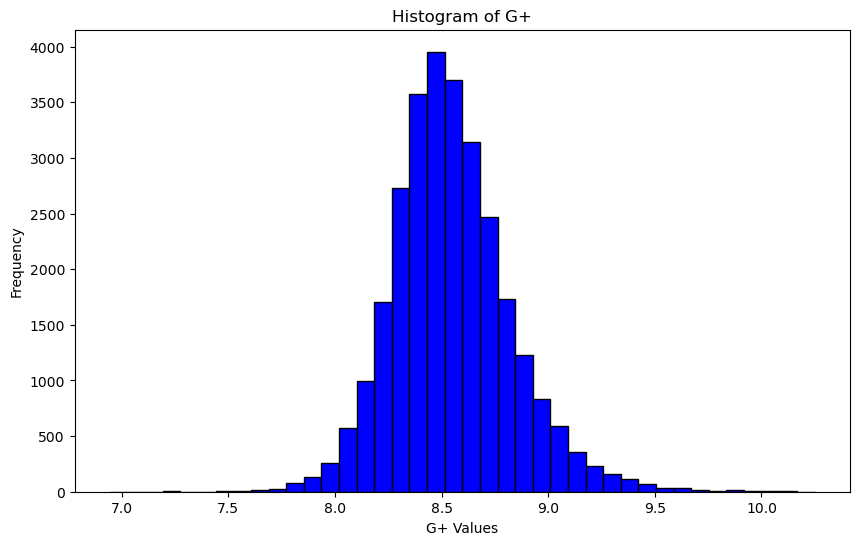

In [18]:
df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')
G_val = df['G+']
# Sample DataFrame creation
# df = pd.DataFrame({'G+': [1, 2, 2, 3, 4, 4, 4, 5, 6, 7, 7, 8, 9, 10]})

# Plotting the histogram
plt.figure(figsize=(10, 6))  # Adjust the size of the figure as needed
plt.hist(df['G+'], bins=40, color='blue', edgecolor='black')  # You can adjust the number of bins
plt.title('Histogram of G+')
plt.xlabel('G+ Values')
plt.ylabel('Frequency')

# Show the plot
plt.show()


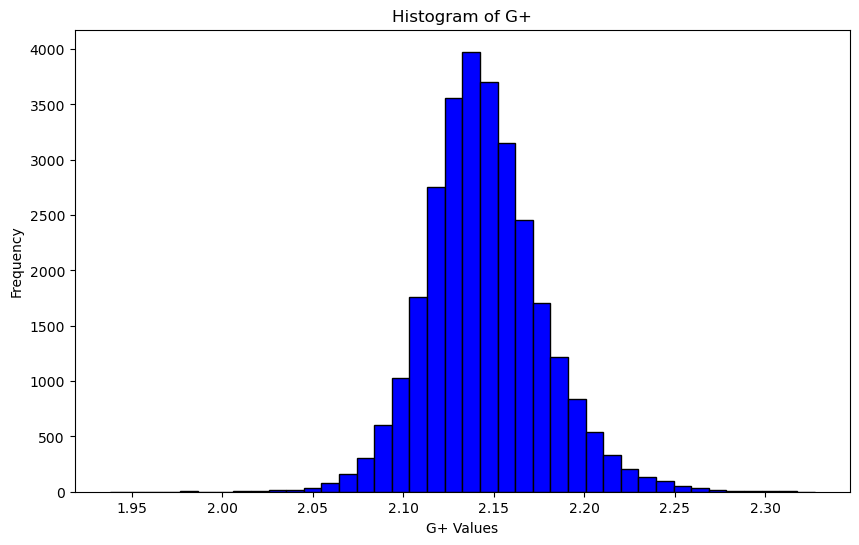

In [22]:
G_val = df['G+']
G_val = np.array(G_val)
G_val = np.log(G_val)
plt.figure(figsize=(10, 6))  # Adjust the size of the figure as needed
plt.hist(G_val, bins=40, color='blue', edgecolor='black')  # You can adjust the number of bins
plt.title('Histogram of G+')
plt.xlabel('G+ Values')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [5]:
df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')
#train, test = split_dataset(df, split_type='fragment', key = 0, seed = 42)
train, test = split_dataset(df, split_type='random', cutoff= 0.8, seed = 42)
train = EnhancerDataset(train, label_mode='G+')
test = EnhancerDataset(test, label_mode='G+')
train_loader = DataLoader(dataset=train, batch_size=10, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=10, shuffle=True)


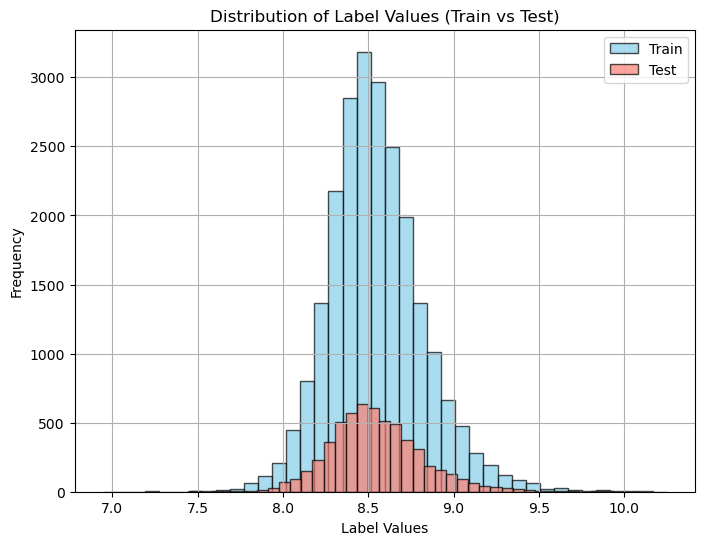

In [3]:
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')

cutoff = 0.8
seed = 44

# Step 1: Create quantile-based bins for the 'G+' column
df['G+_bins'] = pd.qcut(df['G+'], q=10, duplicates='drop')  # Using 10 quantiles as an example

# Step 2: Perform a stratified split based on these bins
train, test  = train_test_split(df, test_size=1-cutoff, random_state=seed, stratify=df['G+_bins'])

train = EnhancerDataset(train, label_mode='G+')
test = EnhancerDataset(test, label_mode='G+')

# Extract label values from the training and test data
train_label_values = [sample[1].item() for sample in train]
test_label_values = [sample[1].item() for sample in test]

# Plot histogram of label values for both train and test datasets
plt.figure(figsize=(8, 6))
plt.hist(train_label_values, bins=40, color='skyblue', alpha=0.7, label='Train', edgecolor='black')
plt.hist(test_label_values, bins=40, color='salmon', alpha=0.7, label='Test', edgecolor='black')
plt.title('Distribution of Label Values (Train vs Test)')
plt.xlabel('Label Values')
plt.ylabel('Frequency')
#plt.ylim(0,10)
plt.legend()
plt.grid(True)
plt.show()


### Model

In [5]:
model = ConvNetDeep(num_classes = 1)
x = torch.randn(10, 4, 608)
print(x.shape)
o = model(x)
print(o.shape)

torch.Size([10, 4, 608])
torch.Size([10, 1])


In [18]:
features, labels = train[0]
dataloader = DataLoader(dataset=train, batch_size=10, shuffle=True)
dataiter = iter(dataloader)
data = next(dataiter)
features, labels = data
print(features.shape, labels.shape)

torch.Size([10, 4, 608]) torch.Size([10])


### Train Model For ConvNetDeep Regression

Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/240, Loss: 67.5971
Epoch 1/200, Step 200/240, Loss: 15.6002
Epoch 1/200: Train Loss: 0.3429 , Test Loss: 0.1744
Epoch 1/200: Train Loss By Batch: 32.9196 , Test Loss By Batch: 16.7396
MSE: 16.7396, RMSE: 4.0914, MAE: 4.0804
R^2: -214.1650, Pearson Correlation: 0.3488, Spearman Correlation: 0.3353
Epoch 2/200, Step 1/240, Loss: 10.3687
Epoch 2/200, Step 200/240, Loss: 1.3377
Epoch 2/200: Train Loss: 0.0403 , Test Loss: 0.0329
Epoch 2/200: Train Loss By Batch: 3.8735 , Test Loss By Batch: 3.1600
Epoch 3/200, Step 1/240, Loss: 0.6824
Epoch 3/200, Step 200/240, Loss: 0.4015
Epoch 3/200: Train Loss: 0.0049 , Test Loss: 0.0160
Epoch 3/200: Train Loss By Batch: 0.4698 , Test Loss By Batch: 1.5344
MSE: 1.5344, RMSE: 1.2387, MAE: 1.1941
R^2: -18.7222, Pearson Correlation: 0.3556, Spearman Correlation: 0.3331
Epoch 4/200, Step 1/240, Loss: 0.3173
Epoch 4/200, Step 200/240, Loss: 0.3506
Epoch 4/200: Train Loss: 0.0034 , Test Loss: 

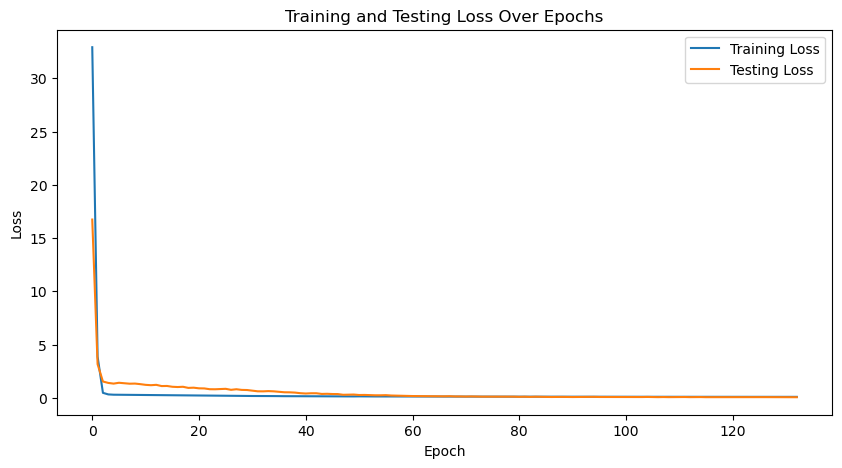

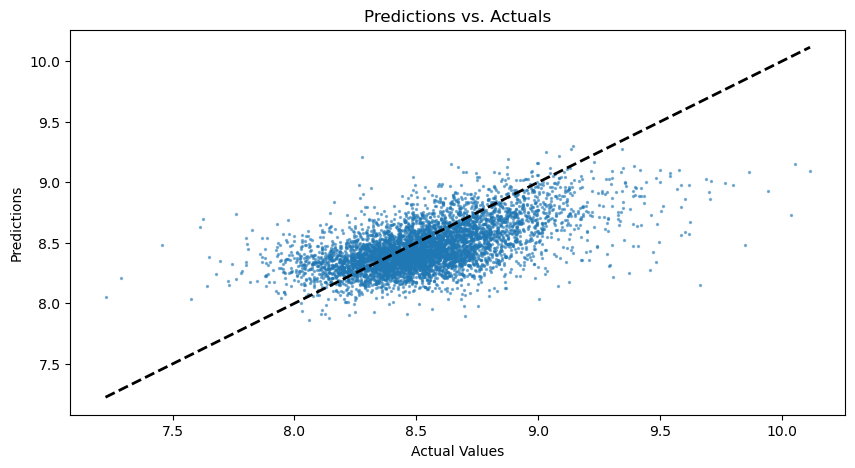

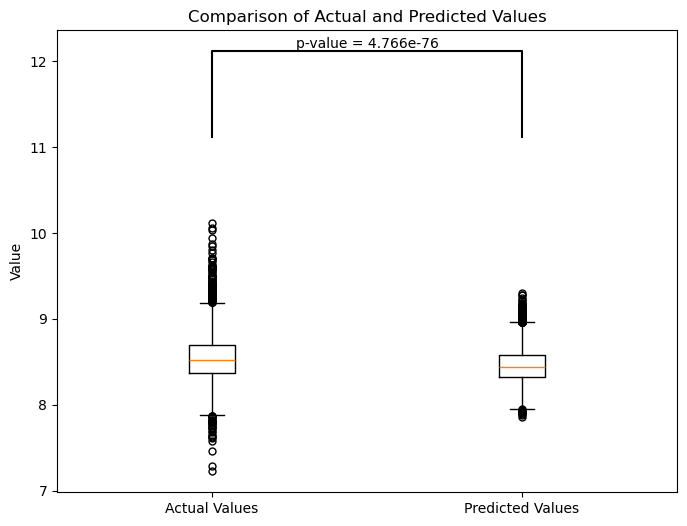

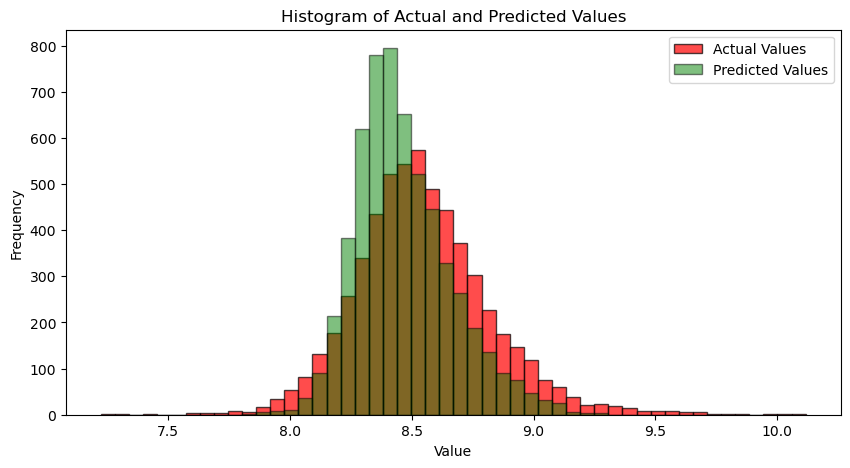

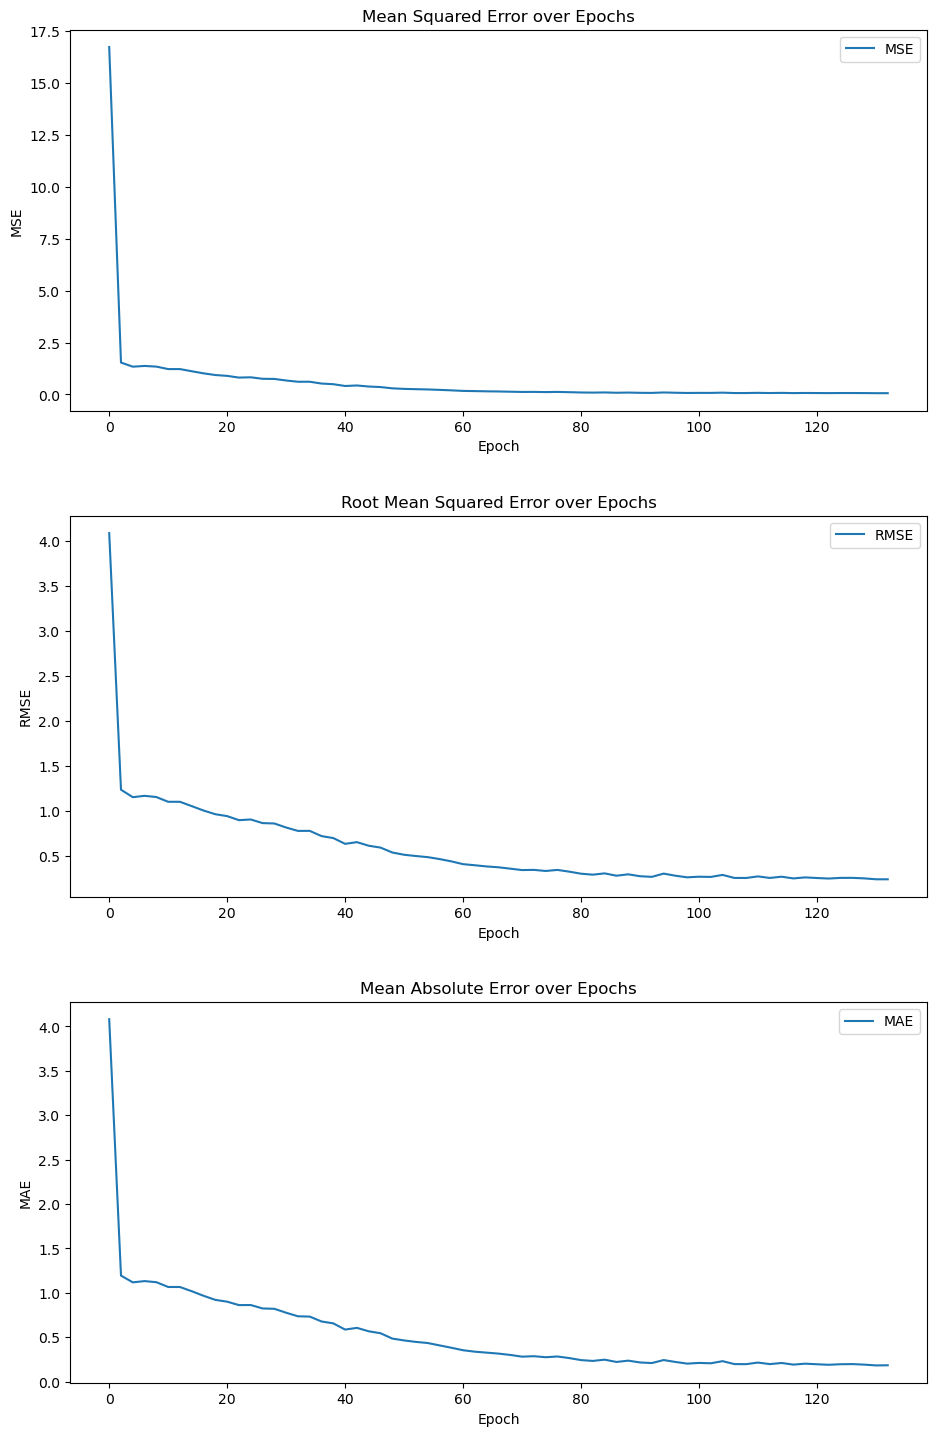

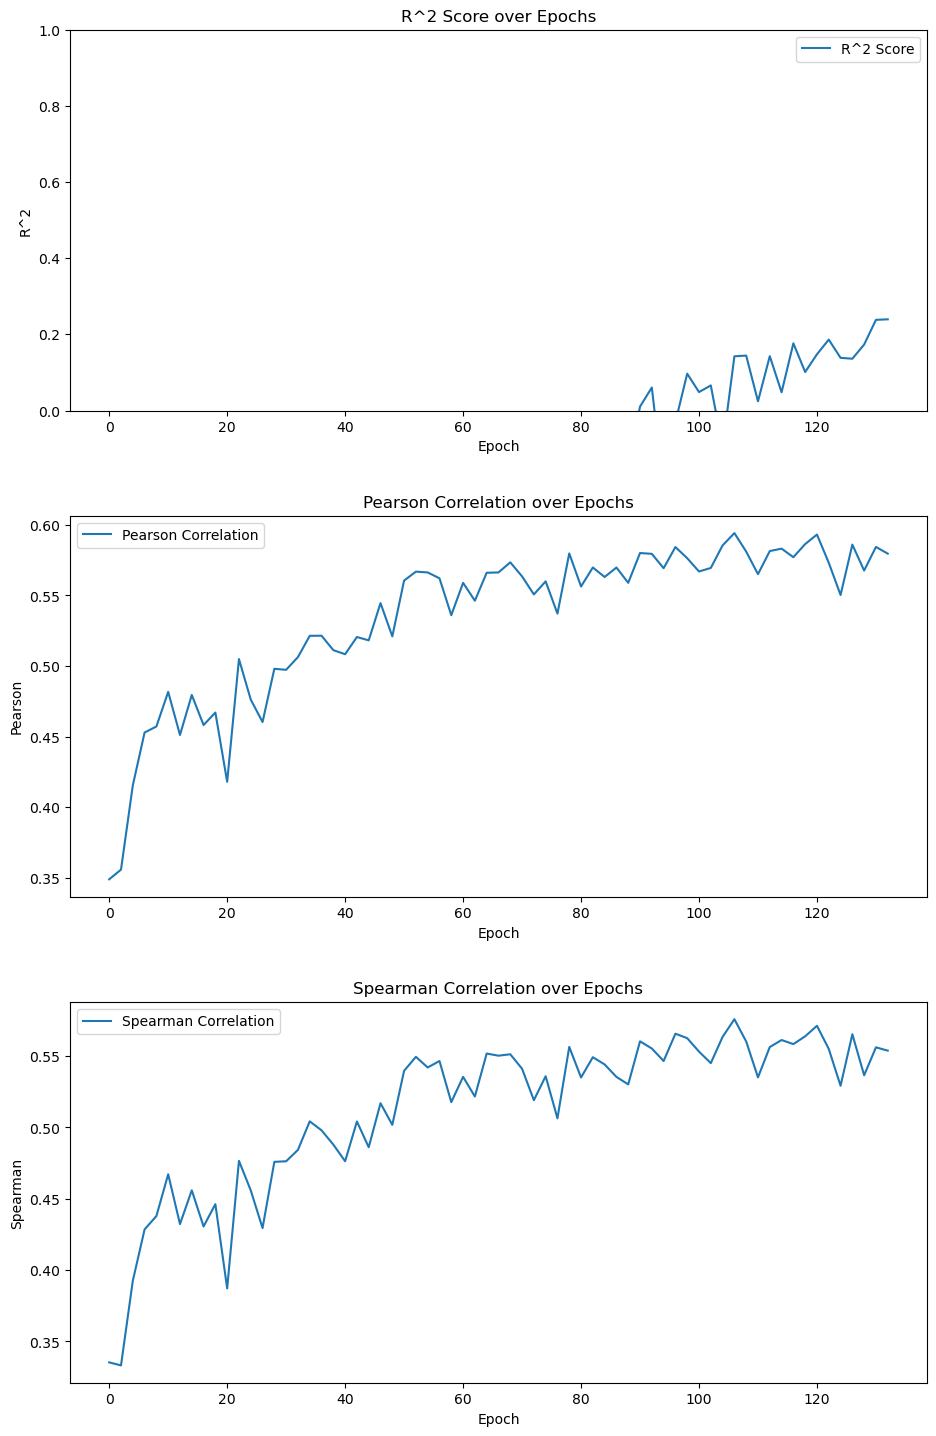

MSE: 0.0592, RMSE: 0.2432, MAE: 0.1847
R^2: 0.2395, Pearson Correlation: 0.5797, Spearman Correlation: 0.5539


In [4]:
#-------------------------------------
#*********Train ConvNetDeep************
#************Predict GFP+**************
#-------------------------------------

# Directory to save the result
seed = 56 
batch = 96
drop_out = 0.3
learning_rate = 6e-5

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train, test = split_dataset(df, split_type='random', cutoff = 0.8, seed = seed)

# Process datasets
train = EnhancerDataset(train, label_mode='G+', scale_mode = 'none')
test = EnhancerDataset(test, label_mode='G+', scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=True)

input_model = ConvNetDeep(num_classes=1, drop_out = drop_out)
# Training
_, _, model, train_losses_by_batch, test_losses_by_batch, results, device  = train_model(input_model, train_loader, test_loader, num_epochs=200, batch_size=batch, learning_rate=learning_rate, criteria='mse',optimizer_type = "adam", patience=15, seed = seed, save_model= False, dir_path=None)

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mse, rmse, mae, r2, pearson_corr, spearman_corr = regression_model_plot(model, test_loader, train_losses_by_batch, test_losses_by_batch, device, results, save_plot = False, dir_path = None)
print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}, Pearson Correlation: {pearson_corr:.4f}, Spearman Correlation: {spearman_corr:.4f}")


### Train Model For DanQ Regression

In [ ]:
#-------------------------------------
#*********Train DanQ************
#********Predict GFP+***********
#-------------------------------------

# Directory to save the result
dir_path = '/pmglocal/ty2514/Enhancer/Enhancer/results/DanQ_70epoch_0001_Gpos_hide0'

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')

batch_size = 20

train, test = split_dataset(df, split_type='random', cutoff = 0.7, seed = 42)
# Process datasets
train = EnhancerDataset(train, label_mode='G+')
test = EnhancerDataset(test, label_mode='G+')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

# Model setup
input_model = DanQ(input_length = 608, num_classes = 1)

train_losses, test_losses, model, train_losses_by_batch, test_losses_by_batch  = train_model(input_model, train_loader, test_loader, num_epochs=70, batch_size=batch_size, learning_rate=0.0001,criteria='mse', optimizer_type = "adam", patience=10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mse, rmse, mae, r2 = evaluate_regression_model(model, test_loader, device)
print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R^2: {r2}")


# Create the directory if it does not exist
os.makedirs(dir_path, exist_ok=True)  # This replaces the if condition

epoch = 70
# After the training loop or during it:
#torch.save(model.state_dict(), f'{dir_path}/model_epoch_{epoch+1}.pth')
#with open(f'{dir_path}/train_losses_epoch_{epoch+1}.pkl', 'wb') as f:
#    pickle.dump(train_losses, f)
#with open(f'{dir_path}/test_losses_epoch_{epoch+1}.pkl', 'wb') as f:
#    pickle.dump(test_losses, f)


### Train For ExplaiNN Regression

Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/240, Loss: 69.0851
Epoch 1/200, Step 200/240, Loss: 51.5904
Epoch 1/200: Train Loss: 58.2346 , Test Loss: 52.2747
------------------------Evaluation------------------------
MSE: 52.2747, RMSE: 7.2301, MAE: 7.2239
R^2: -665.3158, Pearson Correlation: 0.3283, Spearman Correlation: 0.3169
----------------------------------------------------------
Epoch 2/200, Step 1/240, Loss: 48.1843
Epoch 2/200, Step 200/240, Loss: 34.0639
Epoch 2/200: Train Loss: 39.5015 , Test Loss: 37.9095
------------------------Evaluation------------------------
MSE: 37.9095, RMSE: 6.1571, MAE: 6.1497
R^2: -482.2101, Pearson Correlation: 0.3720, Spearman Correlation: 0.3588
----------------------------------------------------------
Epoch 3/200, Step 1/240, Loss: 32.4184
Epoch 3/200, Step 200/240, Loss: 22.1660
Epoch 3/200: Train Loss: 26.1045 , Test Loss: 26.4983
------------------------Evaluation------------------------
MSE: 26.4983, RMSE: 5.1477, M

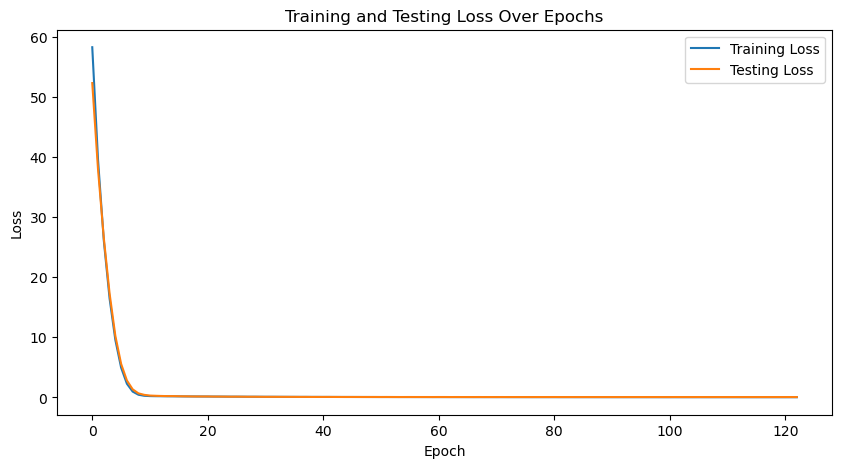

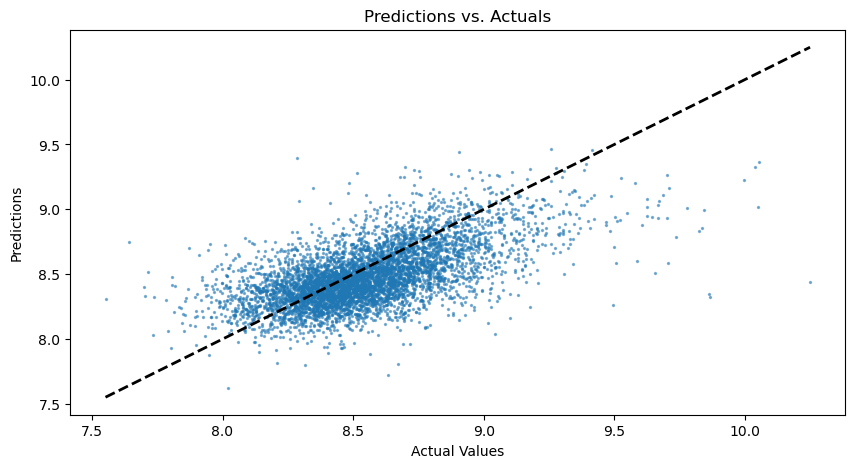

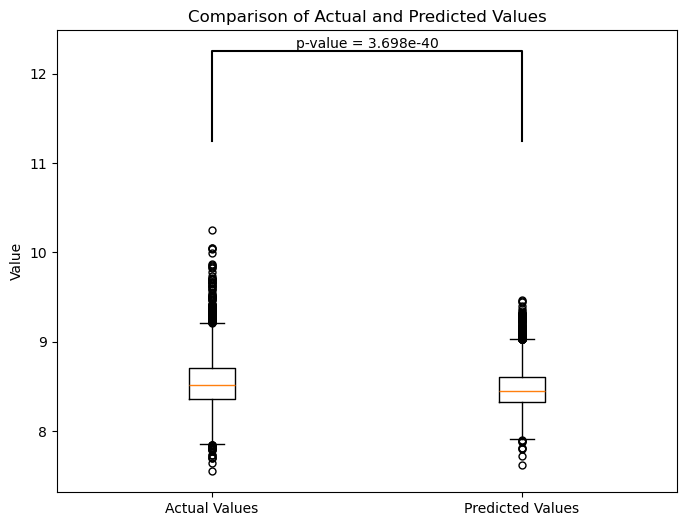

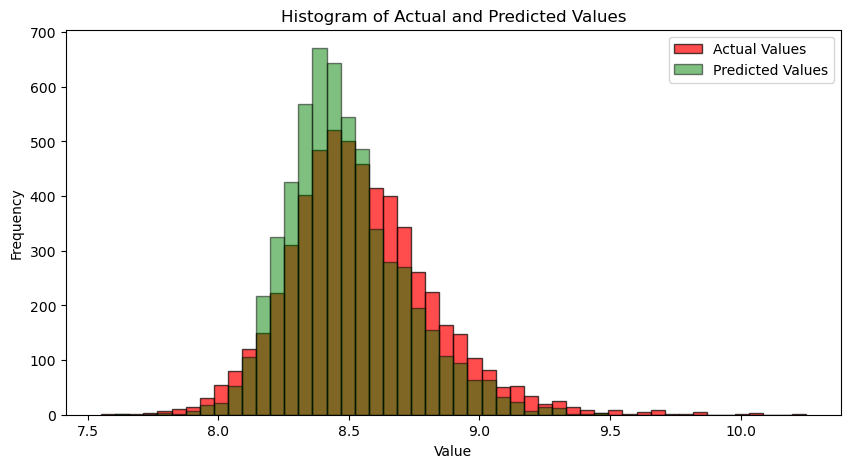

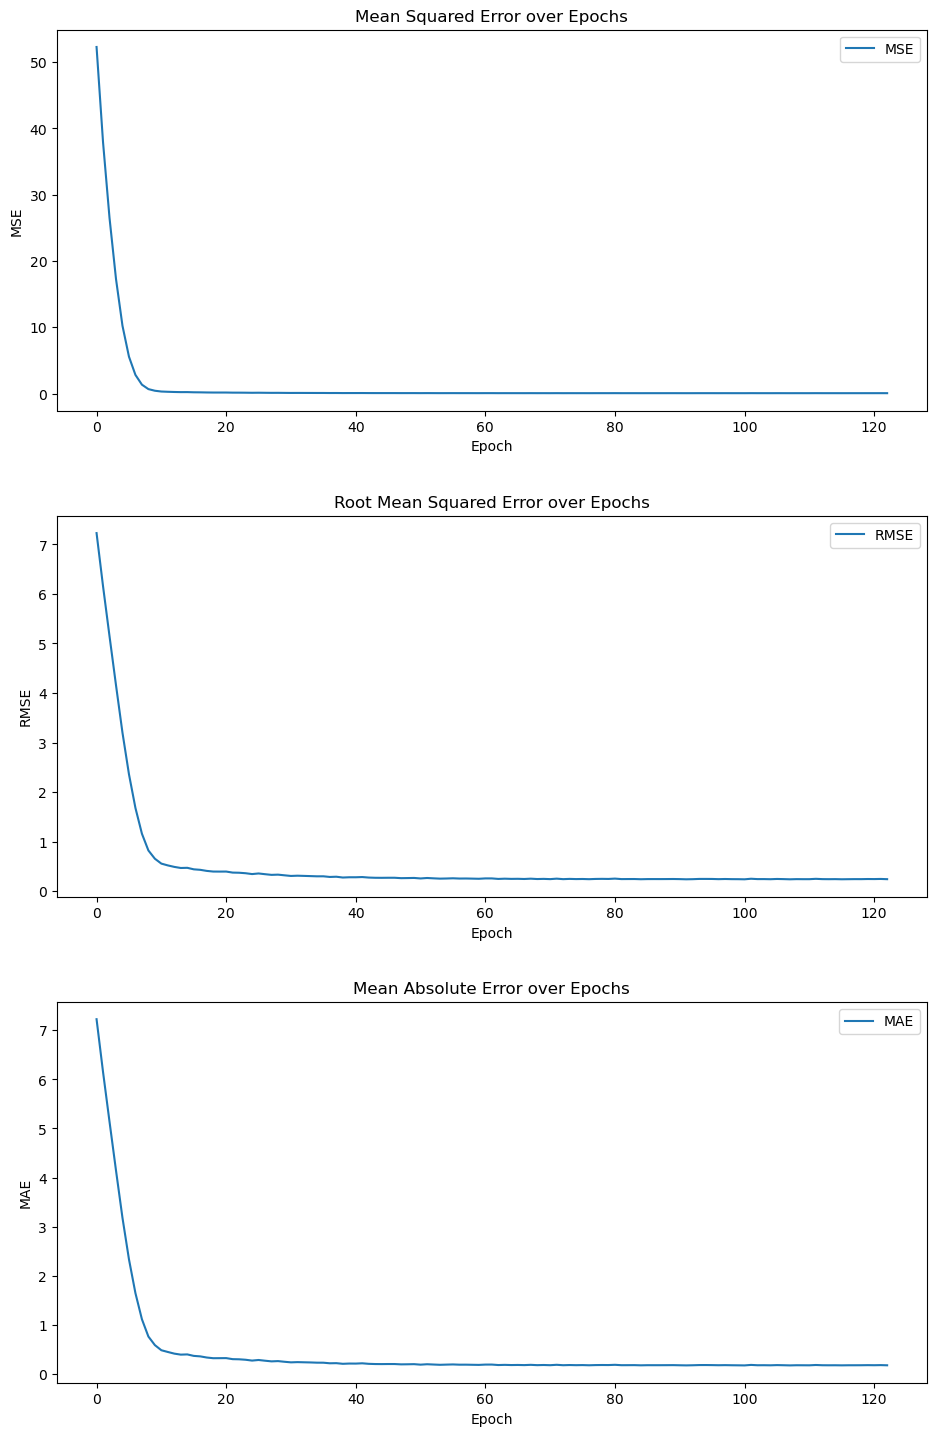

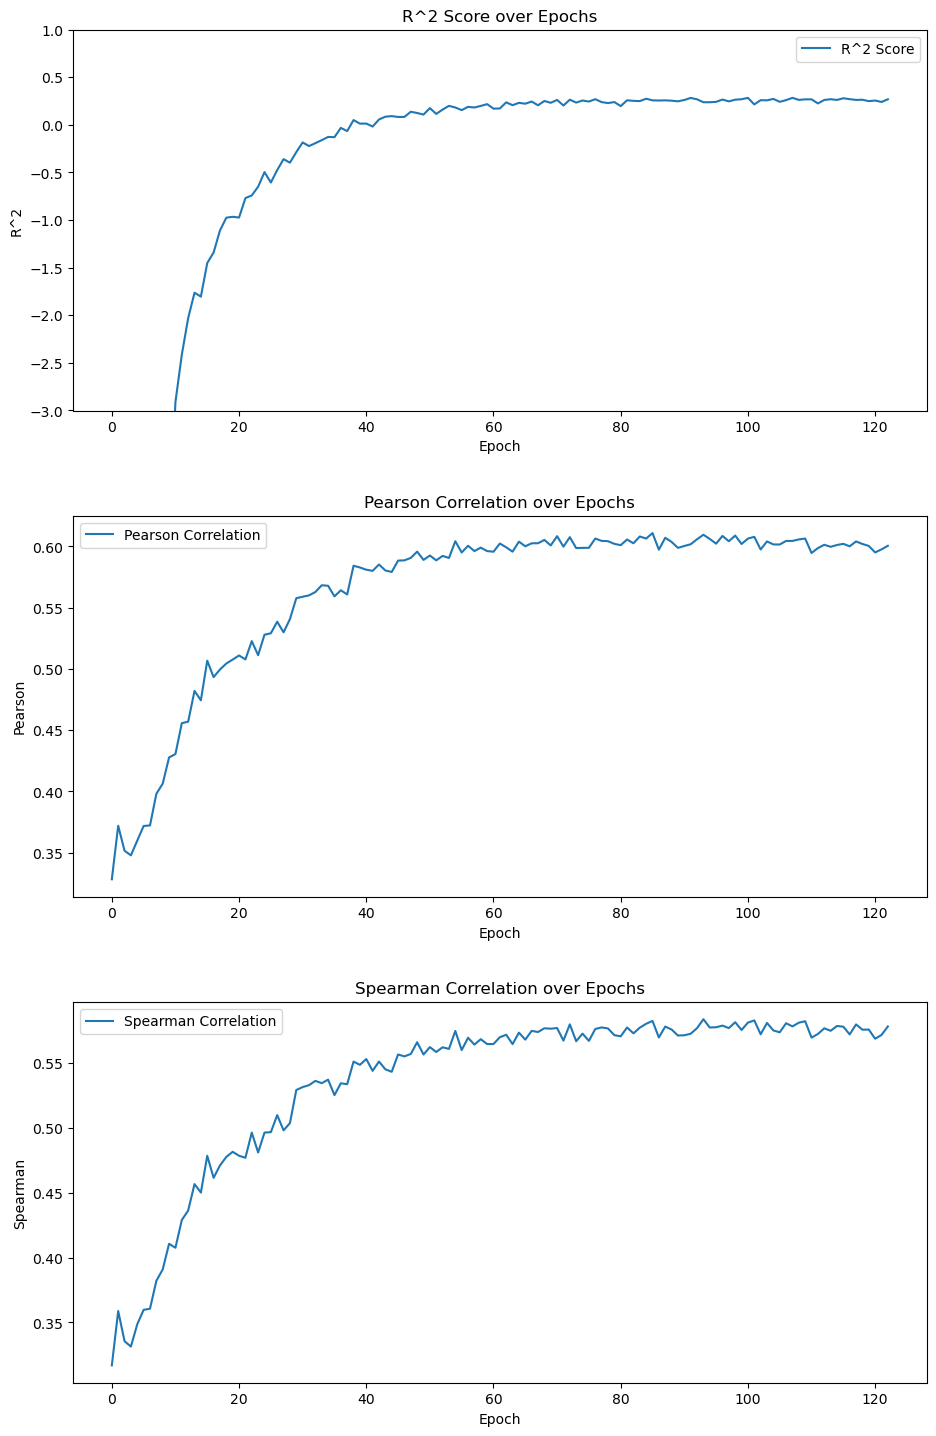

MSE: 0.0574, RMSE: 0.2395, MAE: 0.1814
R^2: 0.2687, Pearson Correlation: 0.6005, Spearman Correlation: 0.5780


In [5]:
# Directory to save the result
seed = 42 
#batch = [24,48,96,168,224]
batch = 96
num_cnns = 10
learning_rate=5e-5

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train, test = split_dataset(df, split_type='random', cutoff = 0.8, seed = seed)

# Process datasets
train = EnhancerDataset(train, label_mode='G+', scale_mode = 'none')
test = EnhancerDataset(test, label_mode='G+', scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=True)

#input_model = ExplaiNN2(num_cnns = 256, input_length = 608, num_classes = 2, 
#                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
#                 fc_filter1 = 20, fc_filter2 = 1, drop_out = 0.3, weight_path = None)# Training

input_model = ExplaiNN3(num_cnns = 256, input_length = 608, num_classes = 1, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, device  = train_model(input_model, train_loader, test_loader, num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= False, dir_path=None)

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mse, rmse, mae, r2, pearson_corr, spearman_corr = regression_model_plot(model, test_loader, train_losses_by_batch, test_losses_by_batch, device, results, label_mode = "G+", save_plot = False, dir_path = None)
print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}, Pearson Correlation: {pearson_corr:.4f}, Spearman Correlation: {spearman_corr:.4f}")

In [18]:
model_path = f'/pmglocal/ty2514/Enhancer/Enhancer/results/ExplaiNN2/model_epoch_{best_pearson_epoch}.pth'
input_model.load_state_dict(torch.load(model_path))
input_model.eval()

ExplaiNN3(
  (linears): Sequential(
    (0): Conv1d(1024, 256, kernel_size=(19,), stride=(1,), groups=256)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ExpActivation()
    (3): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Unsqueeze()
    (6): Conv1d(21504, 25600, kernel_size=(1,), stride=(1,), groups=256)
    (7): BatchNorm1d(25600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(25600, 256, kernel_size=(1,), stride=(1,), groups=256)
    (11): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (final): Linear(in_features=256, out_features=2, bias=True)
)

### Train for DeepSTARR

In [4]:
# Directory to save the result
seed = 42 
#batch = [24,48,96,168,224]
batch = 96
num_cnns = 10
learning_rate=1e-3

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train, test = split_dataset(df, split_type='random', cutoff = 0.8, seed = seed)

# Process datasets
train = EnhancerDataset(train, label_mode='G+', scale_mode = 'none')
test = EnhancerDataset(test, label_mode='G+', scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=False)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)

#input_model = ExplaiNN2(num_cnns = 256, input_length = 608, num_classes = 2, 
#                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
#                 fc_filter1 = 20, fc_filter2 = 1, drop_out = 0.3, weight_path = None)# Training

input_model = DeepSTARR(num_classes=1)

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, device  = train_model(input_model, train_loader, test_loader, num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= False, dir_path=None)

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mse, rmse, mae, r2, pearson_corr, spearman_corr = regression_model_plot(model, test_loader, train_losses_by_batch, test_losses_by_batch, device, results, label_mode = "G+", save_plot = False, dir_path = None)
print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}, Pearson Correlation: {pearson_corr:.4f}, Spearman Correlation: {spearman_corr:.4f}")

Using device: cpu
Model is on device: cpu
Epoch 1/200, Step 1/240, Loss: 80.9303
Epoch 1/200, Step 200/240, Loss: 1.1783
Epoch 1/200: Train Loss: 10.9856 , Test Loss: 2.7318
------------------------Evaluation------------------------
MSE: 2.7318, RMSE: 1.6528, MAE: 1.5836
R^2: -33.8207, Pearson Correlation: 0.2130, Spearman Correlation: 0.2088
----------------------------------------------------------
Epoch 2/200, Step 1/240, Loss: 1.3893
Epoch 2/200, Step 200/240, Loss: 0.8710
Epoch 2/200: Train Loss: 1.0502 , Test Loss: 2.4991
------------------------Evaluation------------------------
MSE: 2.4991, RMSE: 1.5809, MAE: 1.5139
R^2: -30.8545, Pearson Correlation: 0.2273, Spearman Correlation: 0.2115
----------------------------------------------------------
Epoch 3/200, Step 1/240, Loss: 0.8742
Epoch 3/200, Step 200/240, Loss: 0.8831
Epoch 3/200: Train Loss: 0.9224 , Test Loss: 1.6307
------------------------Evaluation------------------------
MSE: 1.6307, RMSE: 1.2770, MAE: 1.2140
R^2: -19

KeyboardInterrupt: 

### Train model for classification

In [2]:
#-------------------------------------
#*********Train DanQ************
#******Predict Expression*******
#-------------------------------------

# Directory to save the result
dir_path = '/pmglocal/ty2514/Enhancer/Enhancer/results/DanQ_100epoch_e6_batch40_hide0_adam_classification'

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')

batch_size = 40

train, test = split_dataset(df, split_type='random', cutoff = 0.8, seed = 42)
#train, test = split_dataset(df, split_type='fragment', key = 0, seed = 42)

# Process datasets
train = EnhancerDataset(train, label_mode='expression')
test = EnhancerDataset(test, label_mode='expression')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

# Model setup
input_model = DanQ(input_length = 608, num_classes = 2)

train_losses, test_losses, model, train_losses_by_batch, test_losses_by_batch  = train_model(input_model, train_loader, test_loader, num_epochs=100, batch_size=batch_size, learning_rate=1e-6,criteria='bcewithlogits', optimizer_type = "adam", patience=10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mse, rmse, mae, r2 = evaluate_regression_model(model, test_loader, device)
print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R^2: {r2}")

# Create the directory if it does not exist
os.makedirs(dir_path, exist_ok=True)  # This replaces the if condition

epoch = 70
# After the training loop or during it:
#torch.save(model.state_dict(), f'{dir_path}/model_epoch_{epoch+1}.pth')
#with open(f'{dir_path}/train_losses_epoch_{epoch+1}.pkl', 'wb') as f:
#    pickle.dump(train_losses, f)
#with open(f'{dir_path}/test_losses_epoch_{epoch+1}.pkl', 'wb') as f:
#    pickle.dump(test_losses, f)

Using device: cuda
Model is on device: cuda:0
Epoch 1/100, Step 1/576, Loss: 0.6923
Epoch 1/100, Step 200/576, Loss: 0.6844
Epoch 1/100, Step 400/576, Loss: 0.6923
Epoch 1/100: Train Loss: 0.0172, Test Loss: 0.0171
Epoch 2/100, Step 1/576, Loss: 0.6873
Epoch 2/100, Step 200/576, Loss: 0.6547
Epoch 2/100, Step 400/576, Loss: 0.6657
Epoch 2/100: Train Loss: 0.0171, Test Loss: 0.0170
Epoch 3/100, Step 1/576, Loss: 0.6598
Epoch 3/100, Step 200/576, Loss: 0.6889
Epoch 3/100, Step 400/576, Loss: 0.6779
Epoch 3/100: Train Loss: 0.0169, Test Loss: 0.0168
Epoch 4/100, Step 1/576, Loss: 0.6622
Epoch 4/100, Step 200/576, Loss: 0.6721
Epoch 4/100, Step 400/576, Loss: 0.6697
Epoch 4/100: Train Loss: 0.0167, Test Loss: 0.0166
Epoch 5/100, Step 1/576, Loss: 0.6554
Epoch 5/100, Step 200/576, Loss: 0.6426
Epoch 5/100, Step 400/576, Loss: 0.6925
Epoch 5/100: Train Loss: 0.0166, Test Loss: 0.0165
Epoch 6/100, Step 1/576, Loss: 0.6430
Epoch 6/100, Step 200/576, Loss: 0.6880
Epoch 6/100, Step 400/576, Loss

In [3]:
#-------------------------------------
#*********Train ConvNetDeep**********
#********Predict Expression**********
#-------------------------------------

# Directory to save the result
dir_path = '/pmglocal/ty2514/Enhancer/Enhancer/results/ConvNetDeep_200epoch_e6_batch40_random_adam_classification'

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')

batch_size = 40

train, test = split_dataset(df, split_type='random', cutoff = 0.8, seed = 42)
#train, test = split_dataset(df, split_type='fragment', key = 0, seed = 42)

# Process datasets
train = EnhancerDataset(train, label_mode='expression')
test = EnhancerDataset(test, label_mode='expression')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

# Model setup
input_model = ConvNetDeep(num_classes=2)

train_losses, test_losses, model, train_losses_by_batch, test_losses_by_batch  = train_model(input_model, train_loader, test_loader, num_epochs=200, batch_size=batch_size, learning_rate=1e-6,criteria='bcewithlogits', optimizer_type = "adam", patience=10)

# Create the directory if it does not exist
os.makedirs(dir_path, exist_ok=True)  # This replaces the if condition

epoch = 70
# After the training loop or during it:
#torch.save(model.state_dict(), f'{dir_path}/model_epoch_{epoch+1}.pth')
#with open(f'{dir_path}/train_losses_epoch_{epoch+1}.pkl', 'wb') as f:
#    pickle.dump(train_losses, f)
#with open(f'{dir_path}/test_losses_epoch_{epoch+1}.pkl', 'wb') as f:
#   pickle.dump(test_losses, f)

Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/576, Loss: 0.7350
Epoch 1/200, Step 200/576, Loss: 0.6912
Epoch 1/200, Step 400/576, Loss: 0.6719
Epoch 1/200: Train Loss: 0.0170, Test Loss: 0.0161
Epoch 2/200, Step 1/576, Loss: 0.6563
Epoch 2/200, Step 200/576, Loss: 0.6539
Epoch 2/200, Step 400/576, Loss: 0.7181
Epoch 2/200: Train Loss: 0.0161, Test Loss: 0.0155
Epoch 3/200, Step 1/576, Loss: 0.6427
Epoch 3/200, Step 200/576, Loss: 0.7216
Epoch 3/200, Step 400/576, Loss: 0.5674
Epoch 3/200: Train Loss: 0.0156, Test Loss: 0.0152
Epoch 4/200, Step 1/576, Loss: 0.5716
Epoch 4/200, Step 200/576, Loss: 0.6401
Epoch 4/200, Step 400/576, Loss: 0.5631
Epoch 4/200: Train Loss: 0.0153, Test Loss: 0.0151
Epoch 5/200, Step 1/576, Loss: 0.6943
Epoch 5/200, Step 200/576, Loss: 0.7091
Epoch 5/200, Step 400/576, Loss: 0.5583
Epoch 5/200: Train Loss: 0.0152, Test Loss: 0.0150
Epoch 6/200, Step 1/576, Loss: 0.6538
Epoch 6/200, Step 200/576, Loss: 0.6657
Epoch 6/200, Step 400/576, Loss

In [ ]:
#-------------------------------------
#*********Train ExplainNN************
#*******Predict Expression***********
#-------------------------------------

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')

batch_size = 40

train, test = split_dataset(df, split_type='random', cutoff = 0.8, seed = 42)
#train, test = split_dataset(df, split_type='fragment', key = 0, seed = 42)

# Process datasets
train = EnhancerDataset(train, label_mode='expression')
test = EnhancerDataset(test, label_mode='expression')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

#for i in range(100):
# Directory to save the result
dir_path = f'/pmglocal/ty2514/Enhancer/Enhancer/results/ExplaiNN5_100epoch_e7_batch40_random_adam_classification'

# Model setup
model = ExplaiNN(num_cnns = 5, input_length = 608, num_classes = 2,filter_size=19, num_fc=1)

train_losses, test_losses, model, train_losses_by_batch, test_losses_by_batch  = train_model(input_model, train_loader, test_loader, num_epochs=100, batch_size=batch_size, learning_rate=1e-6,criteria='bcewithlogits', optimizer_type = "adam", patience=10)

# Create the directory if it does not exist
os.makedirs(dir_path, exist_ok=True)  # This replaces the if condition

epoch = 100
# After the training loop or during it:
save = False
if save == True:
    torch.save(model.state_dict(), f'{dir_path}/model_epoch_{epoch+1}.pth')
    with open(f'{dir_path}/train_losses_epoch_{epoch+1}.pkl', 'wb') as f:
        pickle.dump(train_losses, f)
    with open(f'{dir_path}/test_losses_epoch_{epoch+1}.pkl', 'wb') as f:
        pickle.dump(test_losses, f)

### For Regression Problem

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score,mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import ks_2samp

def evaluate_regression_model(model, test_loader, train_losses, test_losses, train_losses_by_batch, test_losses_by_batch, device, save_plot = False, dir_path = None):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy().flatten()
            predictions.extend(outputs)
            actuals.extend(labels.cpu().numpy().flatten())
    
    # Convert to numpy arrays for easier manipulation
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    print(f"shape of predictions: {predictions.shape}, shape of actuals: {actuals.shape}")
    # Calculating errors and R-squared
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    # Directory setup
    if save_plot == True:
        os.makedirs(dir_path, exist_ok=True)

        # If we want to include the first epoch's loss and start ticks from 1
    epochs = range(2, len(train_losses) + 1)

    # Create ticks every 10 epochs starting from 1
    ticks = range(2, len(train_losses) + 1, 10)

    # Plotting train_losses and test_losses starting from the second epoch
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses[1:], label='Training Loss')  # Skip index 0 by slicing from index 1
    plt.plot(epochs, test_losses[1:], label='Testing Loss')  # Skip index 0 by slicing from index 1
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Over Epochs (Starting from Epoch 2)')
    plt.legend()
    plt.xticks(ticks)  # Set x-ticks to show proper epoch numbers
    if save_plot:
        plt.savefig(os.path.join(dir_path, 'training_testing_loss.png'))
    plt.show()

    # Plotting train_losses and test_losses
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses_by_batch[1:], label='Training Loss')
    plt.plot(epochs, test_losses_by_batch[1:], label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing (By Batch) Loss Over Epochs')
    plt.legend()
    plt.xticks(ticks)
    if save_plot == True:
        plt.savefig(os.path.join(dir_path, 'training_testing_loss_by_batch.png'))
    plt.show()
    
    # Plotting predictions vs actuals
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals, predictions, alpha=0.5, s= 2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predictions')
    plt.title('Predictions vs. Actuals')
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--', lw=2)  # Diagonal line
    if save_plot == True:
        plt.savefig(os.path.join(dir_path, 'Prediction_Actuals_Correlation_Plot.png'))
    plt.show()

    # Plotting bar plots of true and predicted values
    # Perform K-S test
    stat, p_value = ks_2samp(actuals, predictions)

    # Create the box plot
    plt.figure(figsize=(8, 6))
    plt.boxplot([actuals, predictions], labels=['Actual Values', 'Predicted Values'],flierprops={'marker':'o', 'color':'black', 'markersize':5})
    plt.title('Comparison of Actual and Predicted Values')
    plt.ylabel('Value')

    # Annotate with the K-S test results
    x1, x2 = 1, 2  # Columns numbers on your plot
    y, h, col = max(max(actuals), max(predictions)) + 1, 1, 'k'  # y is the height, h is the height of the line, col is the color
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, f'p-value = {p_value:.3e}', ha='center', va='bottom', color=col)
    if save_plot == True:
        plt.savefig(os.path.join(dir_path, 'Prediction_Actuals_bar_plot.png'))
    plt.show()

    residuals = actuals - predictions
    # Plotting residuals
    plt.figure(figsize=(10, 5))
    plt.scatter(predictions, residuals, alpha=0.5)
    plt.xlabel('Predictions')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Predictions')
    plt.axhline(y=0, color='r', linestyle='--')
    if save_plot == True:
        plt.savefig(os.path.join(dir_path, 'Residual_Prediction_plot.png'))
    plt.show()

    # Histogram of true and predicted values
    bins = np.histogram_bin_edges(actuals, bins=50)

    # Plot the histograms using the same bins
    plt.figure(figsize=(10, 5))
    plt.hist(actuals, bins=bins, alpha=0.7, color='red', edgecolor='black', label='Actual Values')
    plt.hist(predictions, bins=bins, alpha=0.5, color='green', edgecolor='black', label='Predicted Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Actual and Predicted Values')
    plt.legend()
    if save_plot:
        plt.savefig(os.path.join(dir_path, 'Prediction_Actuals_histogram.png'))
    plt.show()

    # Histogram of residuals
    plt.figure(figsize=(10, 5))
    plt.hist(residuals, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Residuals')
    plt.title('Histogram of Residuals')
    if save_plot == True:
        plt.savefig(os.path.join(dir_path, 'Residual_histgram.png'))
    plt.show()

    return mse, rmse, mae, r2

### For Classification Problem

(5760,) (5760,)


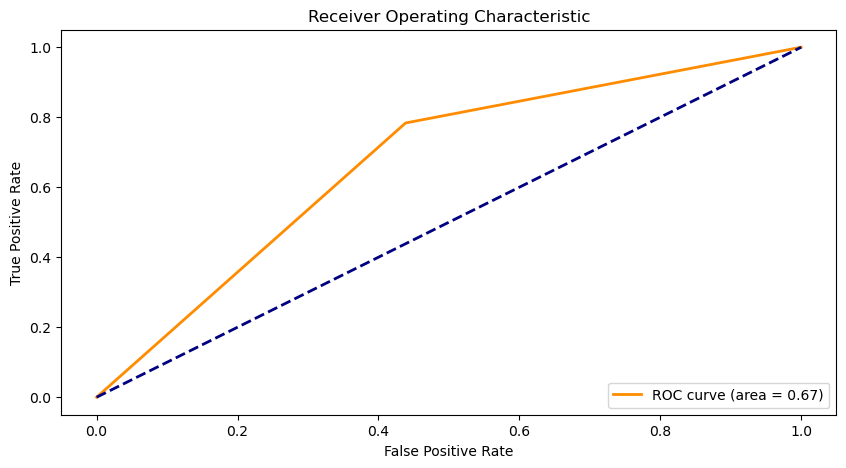

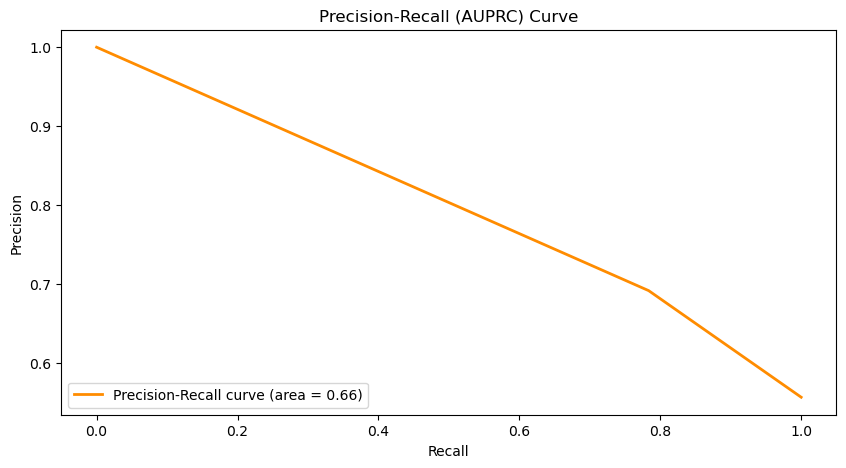

Prediction range:  0 to 1
Threshold 1.00:  (array([0]), array([5760]))
Accuracy: 0.6851, Confusion Matrix: 
[[1434 1120]
 [ 694 2512]], ROC AUC: 0.6725, PR AUC: 0.6624


In [6]:
#model = DanQ(input_length = 608, num_classes = 2)
#model.load_state_dict(torch.load('/pmglocal/ty2514/Enhancer/Enhancer/results/DanQ_100epoch_e6_batch40_Gpos_hide0_adam_classification/model_epoch_71.pth', map_location=torch.device('cpu')))
#train, test = split_dataset(df, split_type='random', cutoff = 0.8, seed = 42)
#train, test = split_dataset(df, split_type='random', key = 0, seed = 42)
#test = EnhancerDataset(test, label_mode='expression')
#test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)


def evaluate_classification_model(model, test_loader, device):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()  # Assuming the output is probability for each class
            predicted_labels = np.argmax(outputs, axis=1)  # Convert probabilities to class indices
            predictions.extend(predicted_labels)
            actuals.extend(np.argmax(labels.cpu().numpy(), axis=1))  # Convert one-hot to class indices
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    print(predictions.shape, actuals.shape)  # Should now match

    # Calculate metrics
    acc = accuracy_score(actuals, predictions)
    cm = confusion_matrix(actuals, predictions)
    fpr, tpr, _ = roc_curve(actuals, predictions)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(actuals, predictions)
    pr_auc = average_precision_score(actuals, predictions)

    # Plot ROC Curve
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    plt.figure(figsize=(10, 5))
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall (AUPRC) Curve')
    plt.legend(loc="lower left")
    plt.show()

    predictions = np.array([pred for pred in predictions])  # Assuming predictions hold probabilities
    print("Prediction range: ", np.min(predictions), "to", np.max(predictions))
    thresholds = np.linspace(0, 1, num=10)
    for thresh in thresholds:
        predicted_classes = (predictions > thresh).astype(int)
    print(f"Threshold {thresh:.2f}: ", np.unique(predicted_classes, return_counts=True))
    
    return acc, cm, roc_auc, pr_auc

# Usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
acc, cm, roc_auc, pr_auc = evaluate_classification_model(model, test_loader, device)
print(f"Accuracy: {acc:.4f}, Confusion Matrix: \n{cm}, ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")




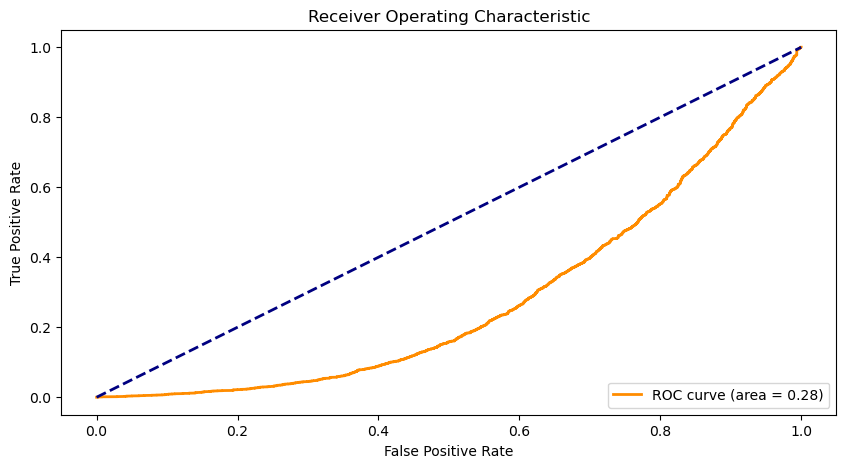

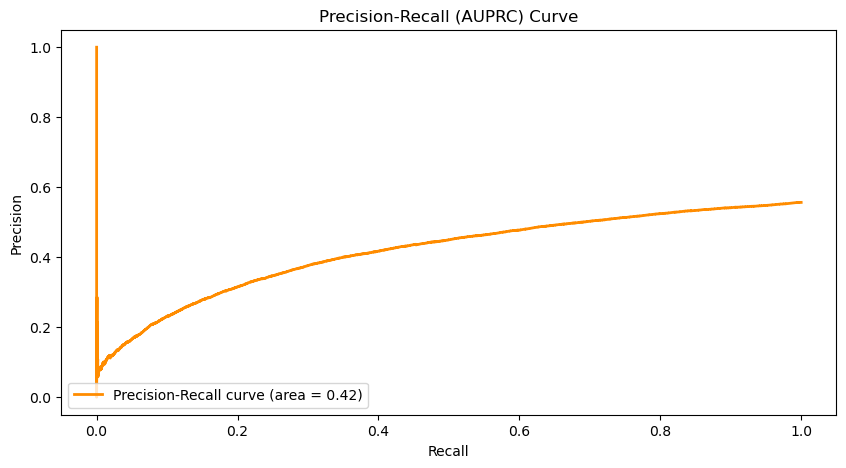

Prediction range:  -2.263227 to 3.7556424
Threshold 0.00:  (array([0, 1]), array([3807, 1953]))
Threshold 0.11:  (array([0, 1]), array([4014, 1746]))
Threshold 0.22:  (array([0, 1]), array([4203, 1557]))
Threshold 0.33:  (array([0, 1]), array([4353, 1407]))
Threshold 0.44:  (array([0, 1]), array([4490, 1270]))
Threshold 0.56:  (array([0, 1]), array([4622, 1138]))
Threshold 0.67:  (array([0, 1]), array([4742, 1018]))
Threshold 0.78:  (array([0, 1]), array([4849,  911]))
Threshold 0.89:  (array([0, 1]), array([4948,  812]))
Threshold 1.00:  (array([0, 1]), array([5041,  719]))
Accuracy: 0.6877, Confusion Matrix: 
[[1357 1197]
 [ 602 2604]], ROC AUC: 0.2800, PR AUC: 0.4172


In [36]:
def evaluate_classification_model(model, test_loader, device):
    model.eval()
    actuals = []
    predictions = []
    probability_outputs = []  # To store raw probabilities of the positive class
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()  # This should be raw probabilities
            predicted_labels = np.argmax(outputs, axis=1)
            predictions.extend(predicted_labels)
            actuals.extend(np.argmax(labels.cpu().numpy(), axis=1))
            probability_outputs.extend(outputs[:, 0])  # Assuming class 0 is 'increase'

    predictions = np.array(predictions)
    actuals = np.array(actuals)
    probability_outputs = np.array(probability_outputs)

    # Calculate metrics
    acc = accuracy_score(actuals, predictions)
    cm = confusion_matrix(actuals, predictions)
    fpr, tpr, _ = roc_curve(actuals, probability_outputs)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(actuals, probability_outputs)
    pr_auc = average_precision_score(actuals, probability_outputs)

    # Plot ROC Curve
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    plt.figure(figsize=(10, 5))
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall (AUPRC) Curve')
    plt.legend(loc="lower left")
    plt.show()

    print("Prediction range: ", np.min(probability_outputs), "to", np.max(probability_outputs))
    thresholds = np.linspace(0, 1, num=10)
    for thresh in thresholds:
        predicted_classes = (probability_outputs > thresh).astype(int)
        print(f"Threshold {thresh:.2f}: ", np.unique(predicted_classes, return_counts=True))
    
    return acc, cm, roc_auc, pr_auc

# Usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
acc, cm, roc_auc, pr_auc = evaluate_classification_model(model, test_loader, device)
print(f"Accuracy: {acc:.4f}, Confusion Matrix: \n{cm}, ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")


